In [1]:
import os
import geopandas as gpd

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32636
# path to data
example_data_path = "./data"

## Input data fetch and parameters setting

In [2]:
from masterplan_tools.method.blocks import CutParameters

city_geometry = gpd.read_parquet(os.path.join(example_data_path, "city_geometry.parquet")).to_crs(local_crs)
water_geometry = gpd.read_parquet(os.path.join(example_data_path, "water_geometry.parquet")).to_crs(local_crs)
roads_geometry = gpd.read_parquet(os.path.join(example_data_path, "roads_geometry.parquet")).to_crs(local_crs)
railways_geometry = gpd.read_parquet(os.path.join(example_data_path, "railways_geometry.parquet")).to_crs(local_crs)

#basically we need just these 4 geometries to cut some blocks
cut_params = CutParameters(
  city=city_geometry,
  water=water_geometry,
  roads=roads_geometry,
  railways=railways_geometry
)

/home/vasilstar/masterplanning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To improve our method we should use land use filtering. If we don't set landuse parameters, no LU filtering will be applied to the blocks

In [3]:
from masterplan_tools.method.blocks import LandUseParameters

no_development = gpd.read_file(os.path.join(example_data_path, "no_development_pzz.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)
no_development = no_development[no_development['RAYON']=='Василеостровский']
landuse = gpd.read_file(os.path.join(example_data_path, "landuse_zone_pzz.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)
buildings_geom = gpd.read_file(os.path.join(example_data_path, "buildings_blocks.geojson"), mask=city_geometry.to_crs(4326)).to_crs(local_crs)

lu_params = LandUseParameters(
  no_development=no_development,
  landuse=landuse,
  buildings=buildings_geom
)

To generate city blocks GeoDataFrame we use the `BlockCutter` class

In [4]:
from masterplan_tools.method import BlocksCutter

blocks = BlocksCutter(
  cut_parameters=cut_params, 
  lu_parameters=lu_params,
).get_blocks()

/home/vasilstar/masterplanning/masterplan_tools/method/blocks/landuse_filter.py:15: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  landuse = ox.geometries_from_polygon(
/home/vasilstar/masterplanning/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1803: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
100%|██████████| 1/1 [00:00<00:00, 22.84it/s]
1410it [00:00, 2264.19it/s]


In [5]:
blocks.head()

,geometry,id,landuse
0,"POLYGON ((344212.162 6646871.964, 344244.125 6...",0,buildings
1,"POLYGON ((343977.009 6647706.702, 343981.163 6...",1,selected_area
2,"POLYGON ((343986.140 6647684.963, 343986.136 6...",2,no_dev_area
3,"POLYGON ((343949.114 6648643.612, 343949.109 6...",3,no_dev_area
4,"POLYGON ((342699.812 6648446.184, 342699.886 6...",4,buildings


There are three landuse tags in the blocks gdf:
1. 'no_dev_area' -- according to th no_debelopment gdf and cutoff without any buildings or specified / selected landuse types;
2. 'selected_area' -- according to the landuse gdf. We separate theese polygons since they have specified landuse types;
3. 'buildings' -- there are polygons that have buildings landuse type. 

In further calculations we will use the in the following steps:
- Only 'buildings' -- to find clusters of buildings in big polygons;
- All of them while calculating the accessibility times among city blocks;
- All of them except 'no_dev_area' while optimizing the development of new facilities.

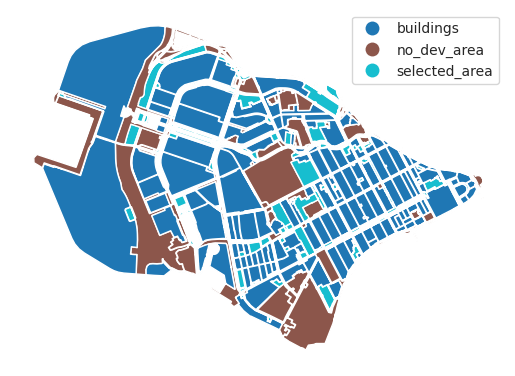

In [13]:
blocks.plot(column='landuse', legend=True).set_axis_off()

Save the result for the next example

In [14]:
blocks.to_parquet(os.path.join(example_data_path, "blocks_cutter_result.parquet"))